# Basic regression with ARIMA errors.

This notebook contains an implemenation of regression with ARIMA errors.

In this implementation months of the year and weeks of the year are represented by seasonal indexes (dummy variables either 0 or 1).

## Imports

In [1]:
import pandas as pd
import numpy as np

from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.datasets import load_emergency_dept

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    start = pd.date_range(start=data.index.max(), periods=2, 
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [3]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None, show_train_size=None, figsize=(12,4)):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    
    if show_train_size is None:
        show_train_size = len(train)
        
    train = train[-show_train_size:]
    ax = train.plot(figsize=figsize)
    

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black', marker='o', ls='')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', 
                   '_ignore','_ignore', '90%PI'], loc=2)

# Function to get seasonal indexes

In [4]:
def get_seasonal_indexes(idx, include_month=True, include_dow=True):
    '''
    Seasonal indexes for use with regression.
    
    Params:
    ------
    idx: pd.DataTimeIndex
        Dates inclued in the dataframe
        
    include_month: bool, optional (default=True)
        Include 11 dummy variables for month of year
        
    include_dow: bool. optional (default=False)
        Include 6 dummy variables for month of year
        
    Returns:
    --------
    pd.DataFrame


    Notes:
    -----
    Modified for 2024. get_dummies return bool by default.
    Used dtype parameter to cast to Int.
    
    '''
    seasonal_idx = pd.DataFrame()
    
    if include_month:
        # uses the pd.get_dummies function 
        seasonal_idx = pd.concat([seasonal_idx, 
                                  pd.get_dummies(idx.month,  
                                                 prefix='m', 
                                                 drop_first=True,
                                                 dtype=int)], axis=1)
        
    if include_dow:
        seasonal_idx = pd.concat([seasonal_idx, 
                                  pd.get_dummies(idx.weekday, prefix='dow', 
                                                 drop_first=True,
                                                 dtype=int)], axis=1)
        
    # set the index
    seasonal_idx.index = idx
        
    return seasonal_idx

## Example with `forecast_tools` ED dataset

In [5]:
TARGET = 0.80
HOLDOUT = 28
PERIOD = 7

# built in dataset
attends = load_emergency_dept()

# train-test split
train = attends[:-HOLDOUT]
test = attends[-HOLDOUT:]

X = get_seasonal_indexes(train.index)
# quick look at 
X.tail(7)

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
date,,,,,,,,,,,,,,,,,
2017-11-27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-11-28,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2017-11-29,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2017-11-30,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2017-12-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2017-12-02,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2017-12-03,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## Use auto_arima with one small change

Pass in the regressors in X 

> Note that in earlier version of `pmdarima` the `X` regressors are known as exogenous variables.

In [6]:
# this will take a few minutes to run and fit all models.
model = auto_arima(train, X=X, m=PERIOD, d=1, supress_warnings=True, 
                   maxiter=100)

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  316
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -1332.236
Date:                Tue, 12 Dec 2023   AIC                           2714.471
Time:                        15:54:17   BIC                           2808.286
Sample:                    01-22-2017   HQIC                          2751.954
                         - 12-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2123      0.109     -1.941      0.052      -0.427       0.002
m_2            8.5956     13.312      0.646      0.518     -17.496      34.688
m_3           19.7908     13.745      1.440      0.150      -7.148      46.730
m_4           30.2987     16.913      1.791      0.073      -2.850      63.447
m_5           46.0311     20.619      2.232      0.026       5.618      86.444
m_6           47.8719     26.053      1.838      0.066      -3.190      98.934
m_7           71.0653     31.032      2.290      0.022      10.244     131.887
m_8           70.5122     36.401      1.937      0.053      -0.832     141.857
m_9           81.9712     40.897      2.004      0.045       1.814     162.128
m_10          93.6182     42.976      2.178      0.029       9.386     177.850
m_11          99.3172     46.122      2.153      0.031       8.921     189.714
m_12         103.6439     48.181      2.151      0.031       9.211     198.076
dow_1         -6.8547      3.515     -1.950      0.051     -13.745       0.036
dow_2         29.6728      3.679      8.066      0.000      22.463      36.883
dow_3         42.7469      3.532     12.102      0.000      35.824      49.670
dow_4         26.7176      3.679      7.262      0.000      19.506      33.929
dow_5          7.7427      3.946      1.962      0.050       0.008      15.478
dow_6         -2.3624      4.007     -0.590      0.555     -10.216       5.491
ar.L1          0.0762      0.064      1.193      0.233      -0.049       0.201
ar.L2          0.0768      0.077      0.994      0.320      -0.075       0.228
ar.L3          0.0604      0.064      0.940      0.347      -0.065       0.186
ar.L4          0.0103      0.070      0.146      0.884      -0.128       0.148
ar.L5          0.0304      0.066      0.459      0.646      -0.099       0.160
ma.L1         -0.9845      0.035    -28.067      0.000      -1.053      -0.916
sigma2       278.8187     25.435     10.962      0.000     228.966     328.671
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.94   Prob(JB):                         0.85
Heteroskedasticity (H):               1.02   Skew:                             0.06
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Making a forecast

We will do this similar to Prophet and create a "future" dataframe that holds all of our regressors for the period we want to predict.

In [8]:
def make_future_dataframe(h, y_train, include_mth=True, include_dow=True):
    '''
    Make a dataframe h steps into the future of y_train
    
    Params:
    ------
    h: int
        Forecast horizon
        
    y_train: pd.DataFrame
        Dataframe containing training data.  Must have a DataTimeIndex
    
    '''
    idx = pd.date_range(start=y_train.iloc[-1].name, periods=y_train.shape[0]+h, 
                        freq='D')
    seasonal_idxs = get_seasonal_indexes(idx, include_month=True, 
                                         include_dow=True)
    return seasonal_idxs.iloc[-h:]


In [9]:
# future_dataframe just holds our X regression i.e. seasonal indexes in the future
future_dataframe = make_future_dataframe(HOLDOUT, train)
future_dataframe.head()

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2018-10-15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2018-10-16,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2018-10-17,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2018-10-18,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2018-10-19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


The forecast function is just for convenience.  It calls the model.predict method

In [10]:
def forecast(model, future_dataframe, return_predict_int=True, alpha=0.05):
    '''
    Forecast with regression with ARIMA errors
    
    Params:
    ------
    h: int
        Forecast horizon
        
    future_dataframe: pd.DataFrame
        Future dataframe containing datetimeindex + seasonal indexes
    
    return_predict_int: bool, optional (default=True)
        Prediction interval with predictions
        
    alpha: float, optional (Deault=0.05)
        1 - coverage for prediction interval
        
    Returns:
    --------
    preds, intervals
    '''
    
    h = future_dataframe.shape[0]
    return model.predict(n_periods=h, X=future_dataframe, 
                         return_conf_int=return_predict_int, 
                         alpha=alpha)

In [11]:
# Forecast and get 95 and 80% prediction intervals 
preds, intervals_95 = forecast(model, future_dataframe, alpha=0.05)
preds, intervals_80 = forecast(model, future_dataframe, alpha=0.2)
intervals = np.array([intervals_80, intervals_95])

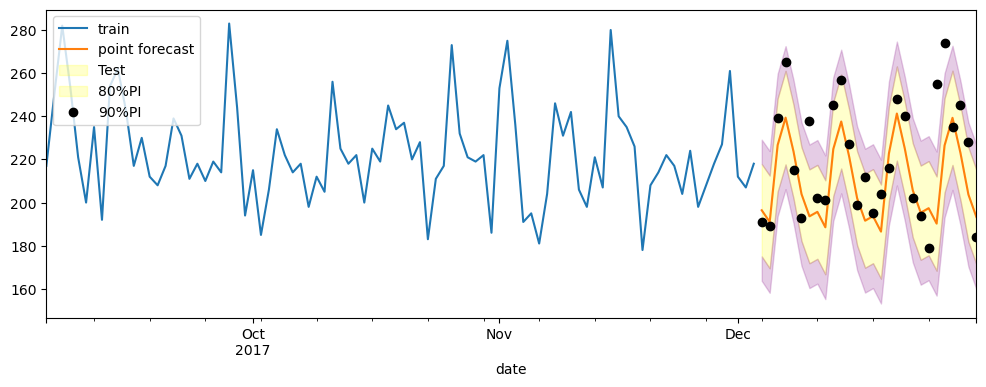

In [12]:
plot_prediction_intervals(train, preds, intervals, test=test, 
                          show_train_size=90)